In [411]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [412]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [413]:
import warnings
warnings.filterwarnings('ignore')

In [414]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

In [415]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [416]:
matplotlib.rcParams.update({'font.size': 14})

In [417]:
TRAIN_DATASET_PATH = '/content/drive/My Drive/DS/train.csv'
TEST_DATASET_PATH = '/content/drive/My Drive/DS/test.csv' 

In [418]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9995,1260,61,2.0,49.090728,33.272626,6.0,3,12.0,1981,0.300323,B,B,52,10311,6,NaN,1,9,B,119367.455796
9996,16265,27,2.0,64.307684,37.038420,9.0,13,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,199715.148807
9997,2795,178,1.0,29.648057,16.555363,5.0,3,5.0,1958,0.460556,B,B,20,4386,14,NaN,1,5,B,165953.912580
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,B,B,47,8004,3,125.0,3,5,B,171842.411855
9999,7202,94,1.0,35.815476,22.301367,6.0,9,9.0,1975,0.127376,B,B,43,8429,3,NaN,3,9,B,177685.627486


In [419]:
train_df['Id'] = train_df['Id'].astype(str)
train_df['DistrictId'] = train_df['DistrictId'].astype(str)

In [420]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
4995,10379,29,2.0,43.177521,30.339945,5.0,6,5.0,1962,0.069660,B,B,31,6119,4,NaN,1,2,B
4996,16138,38,3.0,93.698122,94.521465,10.0,21,27.0,2018,0.060753,B,B,15,2787,2,520.0,0,7,B
4997,3912,101,1.0,33.656723,19.003259,5.0,2,5.0,1966,0.038693,B,B,28,6533,1,1015.0,2,5,B
4998,5722,10,1.0,38.635155,20.976257,9.0,8,14.0,1970,0.089040,B,B,33,7976,5,NaN,0,11,B
4999,11004,21,2.0,67.122742,33.944344,13.0,9,17.0,2009,0.194489,B,B,47,8004,3,125.0,3,5,B


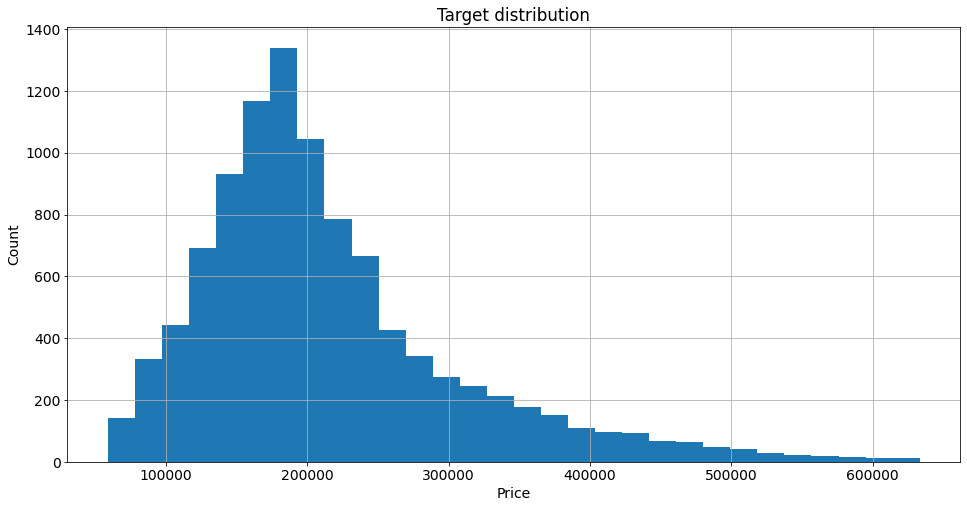

In [421]:
plt.figure(figsize = (16, 8))

train_df['Price'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Price')

plt.title('Target distribution')
plt.show()

In [422]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [423]:
train_df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

In [424]:
train_df.loc[train_df['Rooms'] == 0, 'Rooms'] = 1
train_df.loc[train_df['Rooms'] >= 6, 'Rooms'] = train_df['Rooms'].median()

In [425]:
condition = (train_df['LifeSquare'].isna()) \
             & (~train_df['Square'].isna()) \
             & (~train_df['KitchenSquare'].isna())
        
train_df.loc[condition, 'LifeSquare'] = train_df.loc[condition, 'Square'] \
                                            - train_df.loc[condition, 'KitchenSquare']
train_df.loc[train_df['LifeSquare'] > train_df['Square'], 'LifeSquare'] = train_df['Square'] - train_df['KitchenSquare']

In [426]:
train_df[['LifeSquare','Square']]

,LifeSquare,Square
0,105.027311,115.027311
1,23.169223,39.832524
2,47.671972,78.342215
3,39.409907,40.409907
4,38.562517,64.285067
...,...,...
9995,33.272626,49.090728
9996,37.038420,64.307684
9997,16.555363,29.648057
9998,22.326870,32.330292


In [427]:
train_df.loc[train_df['KitchenSquare'] > train_df['Square'], 'KitchenSquare'] = train_df['Square'] - train_df['LifeSquare']

In [428]:
train_df['KitchenSquare'].value_counts()

1.000000      2460
8.000000      1306
5.000000      1169
10.000000     1075
6.000000      1038
9.000000       843
0.000000       697
7.000000       609
12.000000      249
11.000000      233
13.000000       67
14.000000       51
4.000000        39
15.000000       31
3.000000        22
16.000000       16
20.000000       14
17.000000       12
19.000000       11
18.000000        6
2.000000         4
22.000000        3
51.000000        2
30.000000        2
37.000000        2
25.000000        2
43.000000        2
32.000000        2
112.000000       2
41.000000        2
58.000000        2
72.000000        1
40.000000        1
96.000000        1
48.000000        1
66.000000        1
19.503403        1
75.000000        1
60.000000        1
78.000000        1
0.652759         1
54.000000        1
31.000000        1
35.000000        1
62.000000        1
39.000000        1
36.000000        1
26.000000        1
23.000000        1
29.000000        1
63.000000        1
123.000000       1
12.998269   

In [429]:
train_df[['Floor','HouseFloor']]

,Floor,HouseFloor
0,4,10.0
1,7,8.0
2,2,17.0
3,10,22.0
4,16,16.0
...,...,...
9995,3,12.0
9996,13,0.0
9997,3,5.0
9998,3,9.0


In [430]:
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor'] = train_df['Floor']

In [431]:
train_df.loc[train_df['Floor'] > train_df['HouseFloor'], 'Floor'] = train_df['HouseFloor']

In [432]:
train_df['Floor'].value_counts()

5.0     1036
4.0      897
3.0      881
9.0      739
1.0      719
7.0      642
8.0      635
6.0      615
2.0      592
12.0     506
10.0     404
11.0     368
14.0     350
17.0     347
13.0     307
16.0     301
15.0     251
18.0      75
19.0      64
20.0      58
22.0      56
24.0      45
21.0      44
25.0      29
23.0      28
26.0       3
32.0       2
28.0       2
33.0       1
42.0       1
37.0       1
31.0       1
Name: Floor, dtype: int64

In [433]:
train_df['HouseFloor'].value_counts()

17.0     2338
9.0      1419
12.0     1086
5.0      1052
14.0      638
16.0      583
1.0       504
25.0      377
22.0      344
24.0      178
4.0       158
8.0       154
10.0      145
3.0       144
15.0      128
19.0      112
20.0      108
18.0       94
7.0        82
6.0        74
2.0        64
23.0       42
11.0       42
13.0       39
21.0       34
30.0       21
40.0        7
27.0        6
37.0        4
32.0        4
28.0        3
26.0        2
99.0        2
48.0        2
39.0        2
31.0        1
117.0       1
44.0        1
29.0        1
36.0        1
45.0        1
38.0        1
47.0        1
Name: HouseFloor, dtype: int64

In [434]:
train_df.loc[train_df['HouseYear'] > datetime.now().year, 'HouseYear'] = datetime.now().year

In [435]:
train_df['HouseYear'].sort_values()

6794    1910
2795    1912
2066    1912
6250    1914
7610    1916
        ... 
8296    2020
2350    2020
7246    2020
9163    2021
8828    2021
Name: HouseYear, Length: 10000, dtype: int64

In [436]:
train_df.isna().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare          0
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

In [437]:
train_df['Healthcare_1'].isna()

0        True
1       False
2       False
3        True
4        True
        ...  
9995     True
9996     True
9997     True
9998    False
9999     True
Name: Healthcare_1, Length: 10000, dtype: bool

In [438]:
train_df.loc[train_df['Healthcare_1'].isna(), 'Healthcare_1'] = train_df['Healthcare_1'].mean()

In [439]:
train_df.isna().sum()

Id               0
DistrictId       0
Rooms            0
Square           0
LifeSquare       0
KitchenSquare    0
Floor            0
HouseFloor       0
HouseYear        0
Ecology_1        0
Ecology_2        0
Ecology_3        0
Social_1         0
Social_2         0
Social_3         0
Healthcare_1     0
Helthcare_2      0
Shops_1          0
Shops_2          0
Price            0
dtype: int64

In [440]:
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians=None

    def fit(self, X):
        """Сохранение статистик"""       
        # Расчет медиан
        self.medians = X.median()
        
    def transform(self, X):
        """Трансформация данных"""

        # Rooms
        X.loc[X['Rooms'] == 0, 'Rooms'] = 1
        X.loc[X['Rooms'] >= 6, 'Rooms'] = self.medians['Rooms']
        
        #LifeSquare
        condition = (X['LifeSquare'].isna()) \
             & (~X['Square'].isna()) \
             & (~X['KitchenSquare'].isna())
        
        X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] \
                                            - X.loc[condition, 'KitchenSquare']
        X.loc[X['LifeSquare'] > X['Square'], 'LifeSquare'] = X['Square'] - X['KitchenSquare']

        # KitchenSquare
        X.loc[X['KitchenSquare'] > X['Square'], 'KitchenSquare'] = X['Square'] - X['LifeSquare']
        
        # HouseFloor, Floor
        X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = X['Floor']
        X.loc[X['Floor'] > X['HouseFloor'], 'Floor'] = X['HouseFloor']
        
        # HouseYear
        X.loc[X['HouseYear'] > datetime.now().year, 'HouseYear'] = datetime.now().year
        
        # Healthcare_1
        X.loc[X['Healthcare_1'].isna(), 'Healthcare_1'] = X['Healthcare_1'].mean()
        
        
        X.fillna(self.medians, inplace=True)
        
        return X

In [441]:
binary_to_numbers = {'A': 0, 'B': 1}

train_df['Ecology_2'] = train_df['Ecology_2'].replace(binary_to_numbers)
train_df['Ecology_3'] = train_df['Ecology_3'].replace(binary_to_numbers)
train_df['Shops_2'] = train_df['Shops_2'].replace(binary_to_numbers)

In [442]:
train_df.head(10)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,105.027311,10.0,4.0,10.0,2014,0.075424,1,1,11,3097,0,1142.90446,0,0,1,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7.0,8.0,1966,0.118537,1,1,30,6207,1,1183.00000,1,0,1,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2.0,17.0,1988,0.025609,1,1,33,5261,0,240.00000,3,1,1,282078.720850
3,2352,1,1.0,40.409907,39.409907,1.0,10.0,22.0,1977,0.007122,1,1,1,264,0,1142.90446,0,1,1,168106.007630
4,13866,94,2.0,64.285067,38.562517,9.0,16.0,16.0,1972,0.282798,1,1,33,8667,2,1142.90446,0,6,1,343995.102962
5,5804,99,3.0,62.528465,47.103833,6.0,9.0,9.0,1972,0.012339,1,1,35,5776,1,2078.00000,2,4,1,161044.944138
6,8864,44,1.0,33.938750,21.772930,9.0,1.0,12.0,1968,0.232205,1,1,24,4860,1,80.00000,0,3,1,142402.739272
7,13072,59,2.0,50.391814,32.893256,8.0,8.0,17.0,1986,0.019509,1,1,37,7687,11,176.00000,5,5,1,326174.175191
8,9951,1,1.0,46.887892,44.628132,1.0,12.0,20.0,1977,0.007122,1,1,1,264,0,1142.90446,0,1,1,160400.401732
9,8094,6,3.0,79.867477,75.085125,1.0,3.0,17.0,2014,0.243205,1,1,5,1564,0,540.00000,0,0,1,194756.023945


In [443]:
med_price_by_district = train_df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                            .rename(columns={'Price':'MedPriceByDistrict'})

med_price_by_district.head()

,DistrictId,Rooms,MedPriceByDistrict
0,0,1.0,142799.434052
1,0,2.0,176210.812334
2,0,3.0,300610.359425
3,1,1.0,146735.671740
4,1,2.0,202666.310126


In [444]:
train_df = train_df.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,MedPriceByDistrict
0,11809,27,3.0,115.027311,105.027311,10.0,4.0,10.0,2014,0.075424,1,1,11,3097,0,1142.90446,0,0,1,305018.871089,213530.788443
1,3013,22,1.0,39.832524,23.169223,8.0,7.0,8.0,1966,0.118537,1,1,30,6207,1,1183.00000,1,0,1,177734.553407,146032.829834
2,8215,1,3.0,78.342215,47.671972,10.0,2.0,17.0,1988,0.025609,1,1,33,5261,0,240.00000,3,1,1,282078.720850,244005.272380
3,2352,1,1.0,40.409907,39.409907,1.0,10.0,22.0,1977,0.007122,1,1,1,264,0,1142.90446,0,1,1,168106.007630,146735.671740
4,13866,94,2.0,64.285067,38.562517,9.0,16.0,16.0,1972,0.282798,1,1,33,8667,2,1142.90446,0,6,1,343995.102962,201584.441255


In [445]:
def floor_to_cat(X):

    X['floor_cat'] = 0

    X.loc[X['Floor'] <= 3, 'floor_cat'] = 1  
    X.loc[(X['Floor'] > 3) & (X['Floor'] <= 5), 'floor_cat'] = 2
    X.loc[(X['Floor'] > 5) & (X['Floor'] <= 9), 'floor_cat'] = 3
    X.loc[(X['Floor'] > 9) & (X['Floor'] <= 15), 'floor_cat'] = 4
    X.loc[X['Floor'] > 15, 'floor_cat'] = 5

    return X


def floor_to_cat_pandas(X):
    bins = [0, 3, 5, 9, 15, X['Floor'].max()]
    X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)
    
    X['floor_cat'].fillna(-1, inplace=True)
    return X


def year_to_cat(X):

    X['year_cat'] = 0

    X.loc[X['HouseYear'] <= 1941, 'year_cat'] = 1
    X.loc[(X['HouseYear'] > 1941) & (X['HouseYear'] <= 1945), 'year_cat'] = 2
    X.loc[(X['HouseYear'] > 1945) & (X['HouseYear'] <= 1980), 'year_cat'] = 3
    X.loc[(X['HouseYear'] > 1980) & (X['HouseYear'] <= 2000), 'year_cat'] = 4
    X.loc[(X['HouseYear'] > 2000) & (X['HouseYear'] <= 2010), 'year_cat'] = 5
    X.loc[(X['HouseYear'] > 2010), 'year_cat'] = 6

    return X
    
def year_to_cat_pandas(X):
    bins = [0, 1941, 1945, 1980, 2000, 2010, X['HouseYear'].max()]
    X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)
    
    X['year_cat'].fillna(-1, inplace=True)
    return X

In [446]:
bins = [0, 3, 5, 9, 15, train_df['Floor'].max()]
pd.cut(train_df['Floor'], bins=bins, labels=False)

0       1
1       2
2       0
3       3
4       4
       ..
9995    0
9996    3
9997    0
9998    0
9999    2
Name: Floor, Length: 10000, dtype: int64

In [447]:
bins = [0, 3, 5, 9, 15, train_df['Floor'].max()]
pd.cut(train_df['Floor'], bins=bins)

0         (3.0, 5.0]
1         (5.0, 9.0]
2         (0.0, 3.0]
3        (9.0, 15.0]
4       (15.0, 42.0]
            ...     
9995      (0.0, 3.0]
9996     (9.0, 15.0]
9997      (0.0, 3.0]
9998      (0.0, 3.0]
9999      (5.0, 9.0]
Name: Floor, Length: 10000, dtype: category
Categories (5, interval[float64]): [(0.0, 3.0] < (3.0, 5.0] < (5.0, 9.0] < (9.0, 15.0] <
                                    (15.0, 42.0]]

In [448]:
train_df = year_to_cat(train_df)
train_df = floor_to_cat(train_df)
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,MedPriceByDistrict,year_cat,floor_cat
0,11809,27,3.0,115.027311,105.027311,10.0,4.0,10.0,2014,0.075424,1,1,11,3097,0,1142.90446,0,0,1,305018.871089,213530.788443,6,2
1,3013,22,1.0,39.832524,23.169223,8.0,7.0,8.0,1966,0.118537,1,1,30,6207,1,1183.00000,1,0,1,177734.553407,146032.829834,3,3
2,8215,1,3.0,78.342215,47.671972,10.0,2.0,17.0,1988,0.025609,1,1,33,5261,0,240.00000,3,1,1,282078.720850,244005.272380,4,1
3,2352,1,1.0,40.409907,39.409907,1.0,10.0,22.0,1977,0.007122,1,1,1,264,0,1142.90446,0,1,1,168106.007630,146735.671740,3,4
4,13866,94,2.0,64.285067,38.562517,9.0,16.0,16.0,1972,0.282798,1,1,33,8667,2,1142.90446,0,6,1,343995.102962,201584.441255,3,5


In [449]:
med_price_by_floor_year = train_df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
med_price_by_floor_year.head()

,year_cat,floor_cat,MedPriceByFloorYear
0,1,1,380359.112959
1,1,2,324303.812481
2,1,3,422668.384063
3,1,4,274992.472366
4,2,1,467230.539057


In [450]:
train_df = train_df.merge(med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,MedPriceByDistrict,year_cat,floor_cat,MedPriceByFloorYear
0,11809,27,3.0,115.027311,105.027311,10.0,4.0,10.0,2014,0.075424,1,1,11,3097,0,1142.90446,0,0,1,305018.871089,213530.788443,6,2,161744.506404
1,3013,22,1.0,39.832524,23.169223,8.0,7.0,8.0,1966,0.118537,1,1,30,6207,1,1183.00000,1,0,1,177734.553407,146032.829834,3,3,192213.977261
2,8215,1,3.0,78.342215,47.671972,10.0,2.0,17.0,1988,0.025609,1,1,33,5261,0,240.00000,3,1,1,282078.720850,244005.272380,4,1,205210.068542
3,2352,1,1.0,40.409907,39.409907,1.0,10.0,22.0,1977,0.007122,1,1,1,264,0,1142.90446,0,1,1,168106.007630,146735.671740,3,4,184303.152266
4,13866,94,2.0,64.285067,38.562517,9.0,16.0,16.0,1972,0.282798,1,1,33,8667,2,1142.90446,0,6,1,343995.102962,201584.441255,3,5,177875.703702


In [451]:
#train_df['Price by meter'] = train_df['Square']/train_df['Price']
#train_df.head()

In [452]:
class FeatureGenerator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.med_price_by_district = None
        self.med_price_by_floor_year = None
        self.house_year_max = None
        self.floor_max = None
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
                
        # Target encoding
        ## District, Rooms
        df = X.copy()
        
        if y is not None:
            df['Price'] = y.values
            
            self.med_price_by_district = df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                                            .rename(columns={'Price':'MedPriceByDistrict'})
        
            self.med_price_by_district_median = self.med_price_by_district['MedPriceByDistrict'].median()
            self.price_by_meter = df['Square']/y.values

            
        ## floor, year
        if y is not None:
            self.floor_max = df['Floor'].max()
            self.house_year_max = df['HouseYear'].max()
            df['Price'] = y.values
            df = self.floor_to_cat(df)
            df = self.year_to_cat(df)
            self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
            self.med_price_by_floor_year_median = self.med_price_by_floor_year['MedPriceByFloorYear'].median()
        
    def transform(self, X):
        
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)  # self.binary_to_numbers = {'A': 0, 'B': 1}
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        


        # More categorical features
        X = self.floor_to_cat(X)  # + столбец floor_cat
        X = self.year_to_cat(X)   # + столбец year_cat
        
        # Target encoding
        if self.med_price_by_district is not None:
            X = X.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
            X.fillna(self.med_price_by_district_median, inplace=True)
            
        if self.med_price_by_floor_year is not None:
            X = X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
            X.fillna(self.med_price_by_floor_year_median, inplace=True)
        
        return X
    
    def floor_to_cat(self, X):
        bins = [0, 3, 5, 9, 15, self.floor_max]
        X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)

        X['floor_cat'].fillna(-1, inplace=True) 
        return X
     
    def year_to_cat(self, X):
        bins = [0, 1941, 1945, 1980, 2000, 2010, self.house_year_max]
        X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)

        X['year_cat'].fillna(-1, inplace=True)
        return X
            
    

In [453]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3',
                 'Helthcare_2', 'Shops_1', 'Shops_2']

new_feature_names = ['MedPriceByDistrict', 'MedPriceByFloorYear']

target_name = 'Price'

In [454]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
#train_df = train_df.drop(columns='Id')
X = train_df.drop(columns=target_name)
y = train_df[target_name]

In [455]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

In [456]:
X_valid.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
3644,13331,27,1.0,43.091028,44.337653,0.0,5,9.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A
1828,236,86,1.0,37.753972,21.042126,9.0,11,12.0,1974,0.161976,B,A,31,7010,5,4508.0,3,7,B
6661,757,131,2.0,44.581728,31.525382,4.0,4,4.0,1959,0.000000,B,B,23,3684,2,NaN,0,4,B
9216,4767,11,3.0,76.093025,45.421461,10.0,8,16.0,1978,0.000170,B,B,36,5992,0,NaN,1,1,B
5911,6017,28,2.0,66.912603,33.904185,10.0,18,23.0,2008,0.333892,B,B,30,6564,1,NaN,0,0,B


In [457]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_df = preprocessor.transform(test_df)
X_train.shape, X_valid.shape, test_df.shape

((6700, 19), (3300, 19), (5000, 19))

In [458]:
features_gen = FeatureGenerator()
features_gen.fit(X_train, y_train)

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
test_df = features_gen.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 23), (3300, 23), (5000, 23))

In [459]:
X_train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,floor_cat,year_cat,MedPriceByDistrict,MedPriceByFloorYear
0,11585,23,1.0,43.380798,42.380798,1.0,18.0,25.0,1977,0.075779,1,1,6,1437,3,1155.736857,0,2,1,4,2,104300.893609,179024.238122
1,2917,30,3.0,83.596365,82.596365,1.0,3.0,16.0,1977,0.000078,1,1,22,6398,141,1046.000000,3,23,1,0,2,197241.123890,179525.641685
2,9635,47,2.0,53.610583,31.289235,8.0,12.0,12.0,1979,0.298205,1,1,16,4048,3,1155.736857,1,3,1,3,2,228796.542555,182150.565992
3,8748,3,2.0,51.877576,30.075022,6.0,3.0,9.0,1974,0.265089,1,1,37,5288,0,1937.000000,3,2,1,0,2,184712.770172,179525.641685
4,5704,62,1.0,53.810968,53.810968,0.0,4.0,4.0,1977,0.072158,1,1,2,629,1,1155.736857,0,0,0,1,2,131107.271962,186265.707329


In [460]:
rf_model = RandomForestRegressor(random_state=21, criterion='mse')
rf_model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=21, verbose=0, warm_start=False)

In [461]:
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
21,MedPriceByDistrict,0.649170
3,Square,0.100467
4,LifeSquare,0.032041
14,Social_3,0.021843
0,Id,0.020866
5,KitchenSquare,0.020152
8,HouseYear,0.018435
22,MedPriceByFloorYear,0.017843
7,HouseFloor,0.017335
6,Floor,0.013861


Train R2:	0.966
Test R2:	0.707


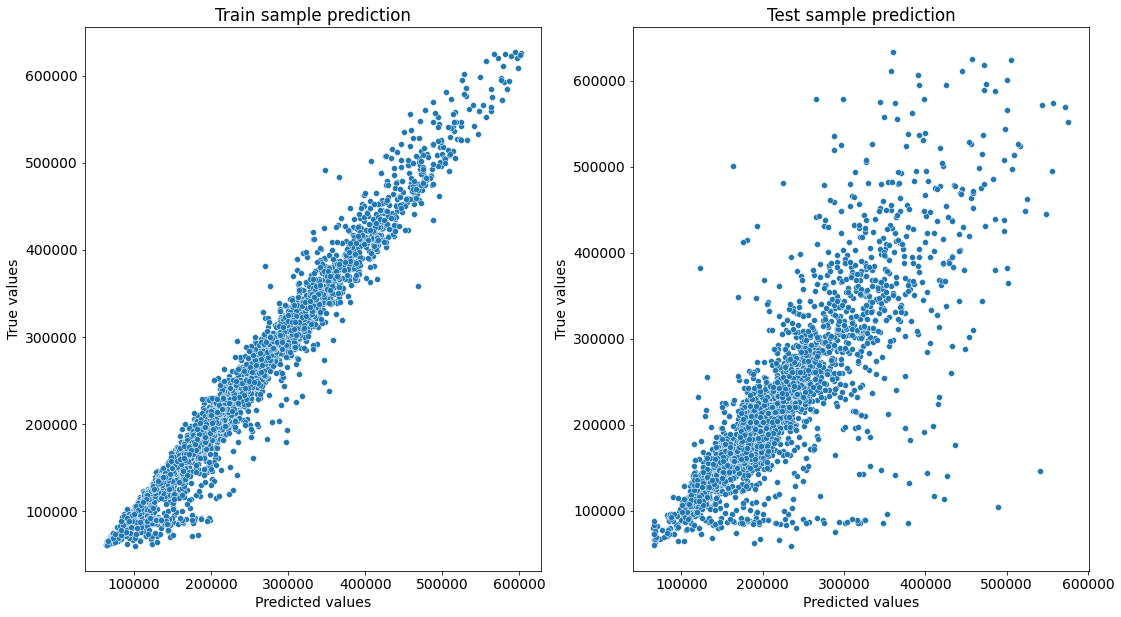

In [462]:
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

In [463]:
cv_score = cross_val_score(rf_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
cv_score
cv_score.mean()

0.7463414600339098

In [464]:
submit = pd.read_csv('/content/drive/My Drive/DS/sample_submission.csv')
submit.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [465]:
predictions = rf_model.predict(test_df)
predictions

array([167096.83755821, 119011.68748064, 138106.12340088, ...,
       147060.96724253, 191414.39830778, 265795.95606962])

In [466]:
submit['Price'] = predictions
submit.head()

,Id,Price
0,4567,167096.837558
1,5925,119011.687481
2,960,138106.123401
3,3848,173437.109527
4,746,175719.798601


In [468]:
submit.to_csv('Bazhan_submit.csv', index=False)